# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [60]:
import numpy as np
from keras import models
from keras import Model
import pandas as pd
from keras.applications.mobilenet import MobileNet,preprocess_input
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,Callback
from keras.layers import Conv2D,Reshape
from keras.backend import epsilon
import tensorflow as tf
np.random.seed(1)


### Change directory

In [2]:
#Mount Google drive
from google.colab import drive
#drive.mount('/gdrive',force_remount=True)
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Lab


/content/drive/My Drive/Lab


### Load the training data from train.csv file

In [50]:
df = pd.read_csv('train_labels.csv')

### Print the shape of the train dataset

In [51]:
df.shape

(173, 8)

In [52]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [53]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [54]:
import csv
with open('train_labels.csv','r') as csvfile:
  paths = []
  coords = np.zeros((sum(1 for line in csvfile) -1,4))
  #print(coords.shape)
  spamreader = csv.reader(csvfile,delimiter=',')
  csvfile.seek(0)
  next(spamreader,None)
  for i , row in enumerate(spamreader):
    for j,r in enumerate(row):
      if((j!=0) & (j!=3)):
        row[j]=int(r)

    path, width, height, class_, xmin, ymin, xmax, ymax = row
    paths.append(path)

    coords[i, 0] = xmin * IMAGE_SIZE / width
    coords[i, 1] = ymin * IMAGE_SIZE / height
    coords[i, 2] = xmax * IMAGE_SIZE / width
    coords[i, 3] = ymax * IMAGE_SIZE / height

print(coords)
  
  # for row in spamreader:
  #  print(row)

[[4.69498069e+01 3.95876289e+01 8.25328185e+01 7.78556701e+01]
 [5.81818182e-01 2.96296296e-01 8.94060606e+01 1.27703704e+02]
 [1.57866667e+01 3.42400000e+01 5.97333333e+01 9.28000000e+01]
 [4.84266667e+01 2.97600000e+01 8.59733333e+01 9.53600000e+01]
 [2.71941392e+01 2.28324324e+01 9.23663004e+01 8.78702703e+01]
 [7.49268293e+00 5.72357724e+00 1.17385366e+02 1.24878049e+02]
 [2.53866667e+01 6.72000000e+00 7.85066667e+01 1.27680000e+02]
 [5.24750958e+01 6.63212435e+00 1.22114943e+02 1.10093264e+02]
 [5.14056225e-01 6.33663366e-01 7.91646586e+01 1.11524752e+02]
 [4.29961390e+01 5.27835052e+00 8.99459459e+01 5.87216495e+01]
 [1.30957096e+01 4.62650602e+00 8.32211221e+01 1.25686747e+02]
 [8.40154440e+00 2.57319588e+01 1.18115830e+02 9.69896907e+01]
 [4.35200000e+00 3.12320000e+01 7.14240000e+01 1.27744000e+02]
 [6.83333333e+00 6.66666667e-01 1.13833333e+02 1.22266667e+02]
 [1.19322034e+01 5.70700637e+00 1.17152542e+02 1.25554140e+02]
 [2.40000000e+01 3.01176471e-01 1.13600000e+02 1.280000

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [55]:
ls -l

total 28
-rw------- 1 root root 11741 Sep 13 09:49 'Copy of LAB - Advanced Computer Vision.ipynb'
drwx------ 2 root root  4096 Sep 13 11:01  images/
drwx------ 2 root root  4096 Sep 13 11:01  images_racoon-1/
-rw------- 1 root root  7913 Sep 13 09:30  train_labels.csv


In [56]:
from PIL import Image
batch_images = np.zeros((len(paths),IMAGE_SIZE,IMAGE_SIZE,3),dtype=np.float32)

for i,f in enumerate(paths):
  img = Image.open('images/'+f)
  img = img.resize((IMAGE_SIZE,IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img,dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [61]:
ALPHA = 1.0
model = MobileNet(input_shape = (IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,alpha = ALPHA)

for layer in model.layers:
  layer.trainable = False
x = model.layers[-1].output
x = Conv2D(4, kernel_size= 4, name = 'coords')(x)
x = Reshape((4,))(x)

model = Model(inputs = model.input , outputs = x)


### Define a custom loss function IoU which calculates Intersection Over Union

In [81]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou


### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [92]:
gt = coords
PATIENCE = 10
model.compile(optimizer  = 'Adam',loss = 'mse',metrics = [IoU])

checkpoint = ModelCheckpoint('model-{val_iou:.2f}.h5',verbose=1,save_best_only=True,save_weights_only=True,mode='max',period=1)
stop = EarlyStopping(monitor='val_iou', patience=PATIENCE, mode='max')
reduce_lr =ReduceLROnPlateau(monitor='val_iou',factor=0.2,aptience=10,min_lr=1e-7,verbose=1,mode='max')
model.fit(batch_images,gt,epochs=30,batch_size=32,verbose=1)

Epoch 1/30
6/6 [==============================] - 2s 310ms/step - loss: 78.8093 - IoU: 0.7768
Epoch 2/30
6/6 [==============================] - 2s 319ms/step - loss: 63.6292 - IoU: 0.8127
Epoch 3/30
6/6 [==============================] - 2s 309ms/step - loss: 59.4630 - IoU: 0.8232
Epoch 4/30
6/6 [==============================] - 2s 309ms/step - loss: 58.6811 - IoU: 0.8180
Epoch 5/30
6/6 [==============================] - 2s 312ms/step - loss: 59.2433 - IoU: 0.8288
Epoch 6/30
6/6 [==============================] - 2s 311ms/step - loss: 57.3809 - IoU: 0.8094
Epoch 7/30
6/6 [==============================] - 2s 317ms/step - loss: 55.5273 - IoU: 0.8654
Epoch 8/30
6/6 [==============================] - 2s 311ms/step - loss: 53.9310 - IoU: 0.8664
Epoch 9/30
6/6 [==============================] - 2s 313ms/step - loss: 53.8703 - IoU: 0.8568
Epoch 10/30
6/6 [==============================] - 2s 312ms/step - loss: 52.0221 - IoU: 0.8788
Epoch 11/30
6/6 [==============================] - 2s 317ms

### Pick a test image from the given data

In [99]:
import cv2
filename = 'images/raccoon-200.jpg'
unscaled = cv2.imread(filename)
print(unscaled)

[[[ 64  61 117]
  [ 65  62 118]
  [ 67  64 120]
  ...
  [ 55  58  56]
  [ 58  61  59]
  [ 60  63  61]]

 [[ 64  58 117]
  [ 67  61 120]
  [ 71  65 122]
  ...
  [ 55  58  56]
  [ 58  61  59]
  [ 60  63  61]]

 [[ 70  64 123]
  [ 72  66 125]
  [ 74  68 127]
  ...
  [ 55  58  56]
  [ 58  61  59]
  [ 60  63  61]]

 ...

 [[ 24  21  67]
  [ 24  21  67]
  [ 24  21  67]
  ...
  [ 62  81  84]
  [ 61  80  83]
  [ 61  80  83]]

 [[ 24  21  67]
  [ 24  21  67]
  [ 24  21  67]
  ...
  [ 66  85  88]
  [ 64  83  86]
  [ 63  82  85]]

 [[ 24  19  70]
  [ 23  18  69]
  [ 23  18  69]
  ...
  [ 60  79  82]
  [ 57  76  79]
  [ 56  75  78]]]


### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [101]:
 image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [102]:
region = model.predict(x= np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

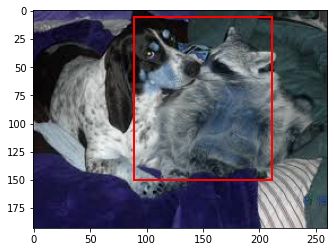

In [103]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()